Notebook adapted from Zoe Ashwood

## 1. Setup
First, you must clone the `ssm` repository and install all of the dependencies. The `ssm` package we are using can be found, along with installation instructions, [here](https://github.com/lindermanlab/ssm.git). 

The line `import ssm` imports the package for use. Here, we have also imported a few other packages for plotting.

In [1]:
import os
# if os.path.basename(os.getcwd()) == 'notebooks':
#     os.chdir('..')
import numpy as np
# import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sglm import hmmUtils, utils
# import ssm

%load_ext autoreload
%autoreload 2

In [2]:
train_split = 0.80
seed = 0
# seed = np.random.randint(1000)
print(seed)

0


#### 1a. Import your data

In [5]:
from bh.models import model_plots as mp


In [3]:
import sys
sys.path.append(f'{os.path.expanduser("~")}/GitHub/behavior-helpers/')
sys.path.append(f'{os.path.expanduser("~")}/GitHub/neural-timeseries-analysis/')

from bh.data.datasets import HFTrials
from bh.models.glmhmm import GLMHMM

data = HFTrials(mice='C37', verbose=False)


C37: 100%|██████████| 17/17 [00:10<00:00,  1.66it/s]


In [4]:
model_kwargs = {'transitions': 'standard',
                # 'trans_kwargs': {'alpha': 2, 'kappa': 0},
                'obs_kwargs': {'C': 2}#, 'prior_sigma': 2}
}

sticky = GLMHMM(num_states=[1, 2, 3, 4], **model_kwargs)

In [70]:
rand_X= pd.DataFrame(data={'a': np.random.randint(2, size=10000),
                                'b': np.random.randint(2, size=10000),
                                'Session': np.random.choice(['c','d', 'e', 'f'], size=10000)})
rand_y = pd.DataFrame(data={'a': np.random.randint(2, size=10000)})
rand_y['Session'] = rand_X['Session'].copy()

In [6]:
sticky.prepare_features(data.trials.copy(), 'direction', nlags=5)
# sticky.X = rand_X
# sticky.y = rand_y
sticky.split_data(ptrain=train_split, verbose=True)

[1. 0.]
[ 1. -1.]
[ 1.  0. -1.]
13 training sessions and 4 test sessions


### 2a. Data and param set up

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Model with 0 states:
     train LL = -0.25
     test LL  = -0.29
Model with 1 states:
     train LL = -0.25
     test LL  = -0.29
Model with 2 states:
     train LL = -0.24
     test LL  = -0.30
Model with 3 states:
     train LL = -0.24
     test LL  = -0.29


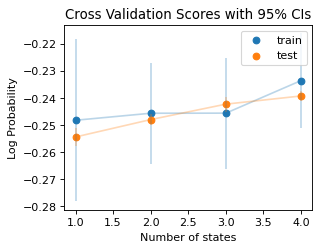

In [7]:
sticky.init_model()
lls, scores = sticky.fit_cv(n_iters=200)
sticky.compare_k_states(scores)


In [16]:
sticky.LL = sticky.calc_log_likelihood(verbose=False)
sticky.LL_norm = sticky.calc_log_likelihood(verbose=True, normalize=True)

Model with 0 states:
     train LL = -0.25
     test LL  = -0.29
Model with 1 states:
     train LL = -0.25
     test LL  = -0.29
Model with 2 states:
     train LL = -0.24
     test LL  = -0.30
Model with 3 states:
     train LL = -0.24
     test LL  = -0.29


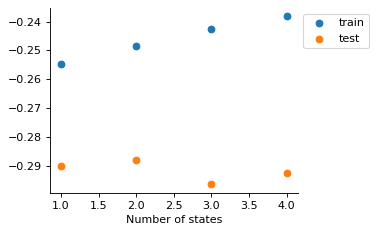

In [24]:
mp.compare_k_states_no_err(sticky, 'LL_norm')

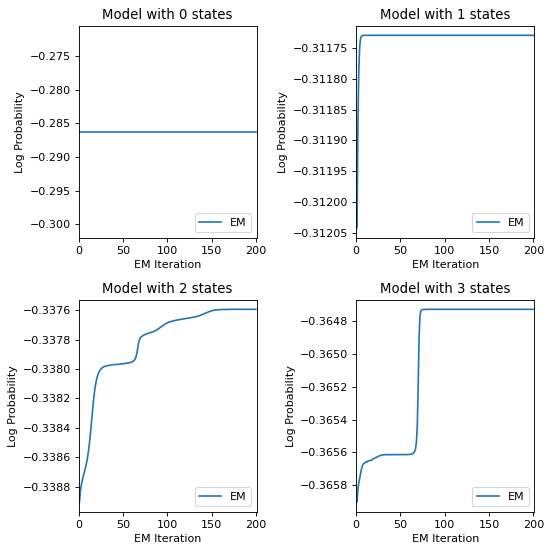

In [8]:
## Plot subplots of the log probabilities of the train and test models. Fit model final LL should be greater
# than or equal to true LL.
fig, axs = plt.subplots(2, 2, figsize=(7, 7), dpi=80,)
for i, (ax, ll) in enumerate(zip(axs.ravel(), lls)):
    ll = np.array(ll) / sticky.train_num_trials
    ax.plot(ll, label="EM")
    # ax.plot([0, len(ll)], LL_norm['test'][i] * np.ones(2), ':k', label="Test")
    ax.legend(loc="lower right")
    ax.set(xlabel="EM Iteration", xlim=(0, len(ll)), ylabel="Log Probability",
           title=f'Model with {i} states')
plt.tight_layout()

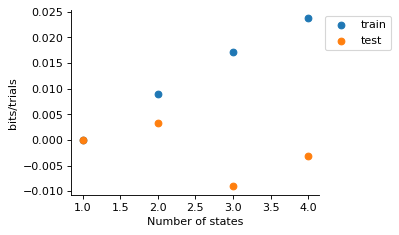

In [27]:
sticky.bits = sticky.calc_log_likelihood(verbose=False, as_bits=True)
sticky.compare_k_states_no_err(bits, ylab='bits/trials')

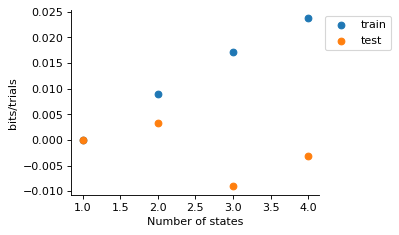

In [29]:
mp.compare_k_states_no_err(sticky, 'bits', ylabel='bits/trials')

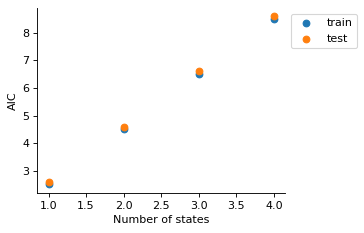

In [30]:
sticky.aic = sticky.calc_aic(LL)
sticky.compare_k_states_no_err(aic, ylab='AIC')

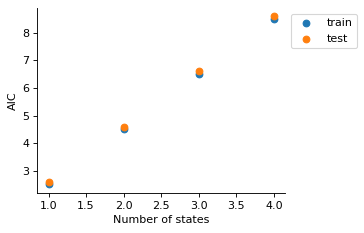

In [33]:
mp.compare_k_states_no_err(sticky, 'AIC', ylabel='AIC')

Model with 0 state(s) has a test predictive accuracy of 0.88759367194005
Model with 1 state(s) has a test predictive accuracy of 0.8859283930058285
Model with 2 state(s) has a test predictive accuracy of 0.8709408825978351
Model with 3 state(s) has a test predictive accuracy of 0.8942547876769359


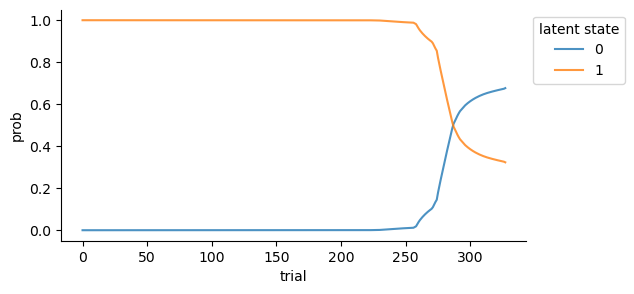

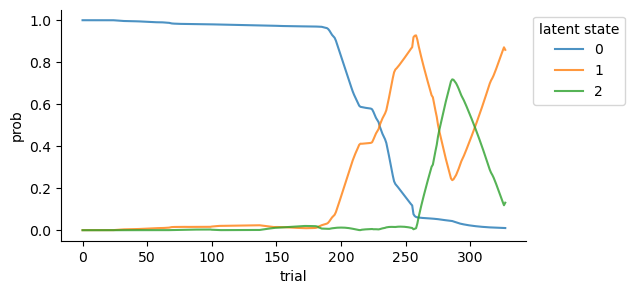

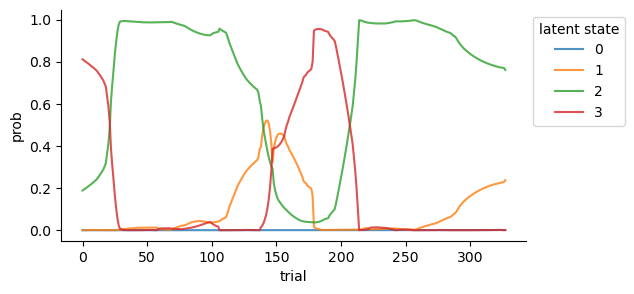

In [34]:
sticky.predict_state()
acc = sticky.predict_choice(accuracy=True, verbose=True)
for i in range(1, 4):
    sticky.plot_state_probs(i, sess_idx=1)

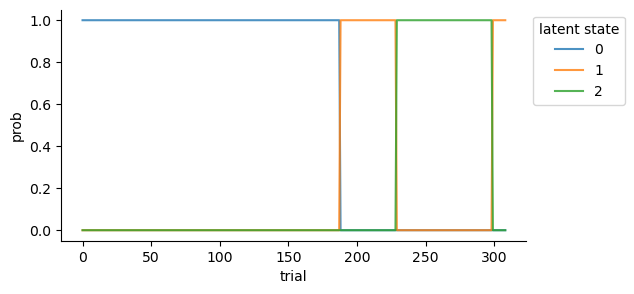

In [12]:
sticky.pred_occupancy()
sticky.plot_state_probs(2, as_occupancy=True, sess_idx=2)

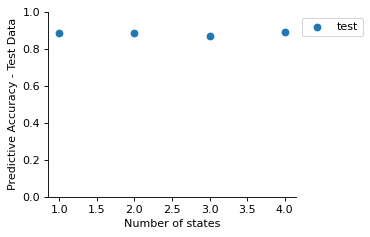

In [38]:
sticky.compare_k_states_no_err({'test': acc}, datasets=['test'],
                                ylab='Predictive Accuracy - Test Data', ylim=(0, 1))

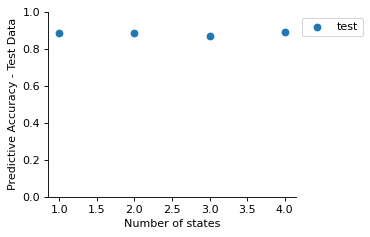

In [37]:
sticky.acc = {'test': acc}
mp.compare_k_states_no_err(sticky, 'accuracy', datasets=['test'], 
ylim=(0,1), ylabel='Predictive Accuracy - Test Data')

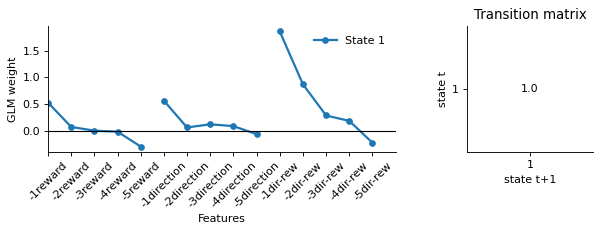

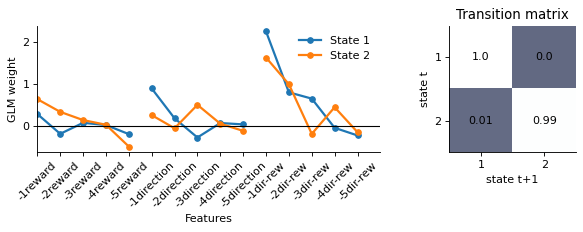

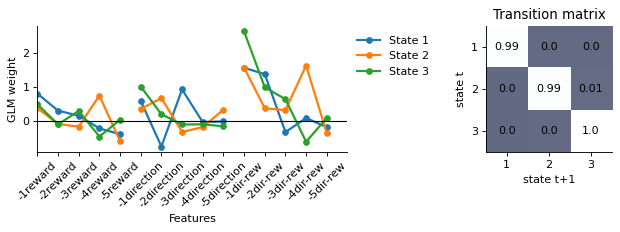

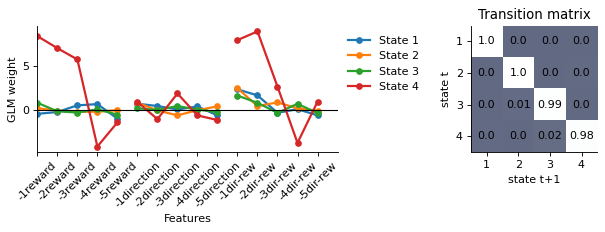

In [39]:
for i in range(4):
    sticky.plot_glm_weights(i)

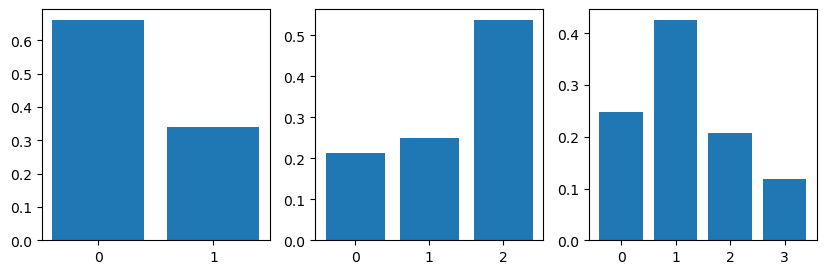

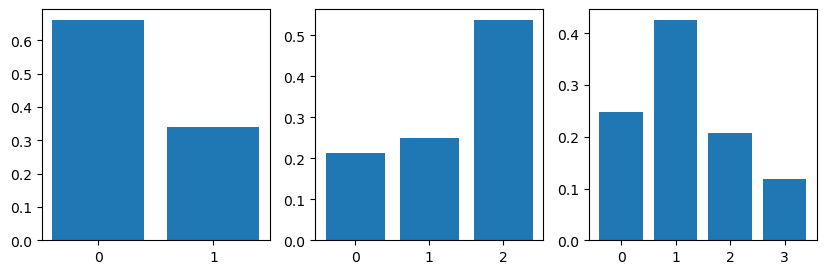

In [40]:
fig, ax = plt.subplots(ncols=3, figsize=(10,3))
for i in range(1,4):
    ax[i-1].bar(range(i+1), sticky.train_occupancy_rates[i])
    ax[i-1].set_xticks(range(i+1))

fig, ax = plt.subplots(ncols=3, figsize=(10,3))
for i in range(1,4):
    ax[i-1].bar(range(i+1), sticky.train_occupancy_rates[i])
    ax[i-1].set_xticks(range(i+1))

### 2b. Option 2 -- Stationary HMM -- input driven, looping through states. Much the same as above except, we are changing the transitions to 'standard'.

In [ ]:

map_glmhmm = ssm.HMM(num_states[i], obs_dim, input_dim, observations="input_driven_obs", 
            observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma),
            transitions="standard")


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]